In [4]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/resources/resources/BBC News Train.csv
/kaggle/input/resources/resources/BBC News Sample Solution.csv
/kaggle/input/resources/resources/BBC News Test.csv


### 1. Introduction

In this project, we explore the task of text classification using both supervised and unsupervised learning approaches. The dataset consists of news articles categorized into five distinct groups: business, tech, politics, sport, and entertainment. To process the textual data, we applied standard natural language processing techniques including cleaning, tokenization, and TF-IDF vectorization to convert text into numerical features. For supervised learning, models such as RandomForestClassifier were trained to predict the correct category using labeled data. In parallel, we employed Non-negative Matrix Factorization (NMF) as an unsupervised method to identify latent topics and group similar documents without using labels. This dual approach allowed us to compare the strengths and weaknesses of both methodologies in terms of accuracy, data efficiency, and performance under varying amounts of labeled data.

#### Import Data

In [41]:
import pandas as pd
file_path ='/kaggle/input/resources/resources/BBC News Sample Solution.csv'
train_path = '/kaggle/input/resources/resources/BBC News Train.csv'
test_path = '/kaggle/input/resources/resources/BBC News Test.csv'

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
sample_solution = pd.read_csv(file_path)

# Step 1 -Extracting word features and show Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

## 1.2  Basic Data Inspection

In [42]:
print(train.head())
print(test.head())

   ArticleId                                               Text  Category
0       1833  worldcom ex-boss launches defence lawyers defe...  business
1        154  german business confidence slides german busin...  business
2       1101  bbc poll indicates economic gloom citizens in ...  business
3       1976  lifestyle  governs mobile choice  faster  bett...      tech
4        917  enron bosses in $168m payout eighteen former e...  business
   ArticleId                                               Text
0       1018  qpr keeper day heads for preston queens park r...
1       1319  software watching while you work software that...
2       1138  d arcy injury adds to ireland woe gordon d arc...
3        459  india s reliance family feud heats up the ongo...
4       1020  boro suffer morrison injury blow middlesbrough...


In [7]:
print(train.shape)
print(test.shape)

(1490, 3)
(735, 2)


#### 2.2. Inspect null values

In [8]:
train.isnull().sum()

ArticleId    0
Text         0
Category     0
dtype: int64

In [9]:
print(train["Text"][0])
print(train["Category"][0])

worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a  green light  to the procedures and practices used by worldcom. mr ebbe

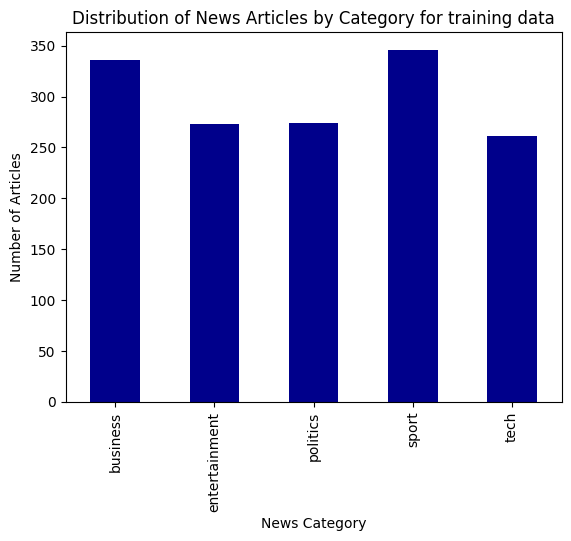

In [10]:
# Group by category and count the number of texts
train_cat = train.groupby('Category').count()

# Plot using a specific color (e.g., skyblue)
train_cat['Text'].plot(kind='bar', color='darkblue')

# Add labels and title
plt.xlabel('News Category')
plt.ylabel('Number of Articles')
plt.title('Distribution of News Articles by Category for training data')

# Show the plot
plt.show()


The training dataset consists of 1,490 rows and 3 columns, while the test dataset contains 735 rows and 2 columns. The key features in the data—Text and Category—are of the object data type. A preliminary analysis shows that there are no missing values in either dataset. The classification task involves five categories: business, tech, politics, sport, and entertainment. 

The most frequent categories in the dataset are Business and Sport. Based on the histogram, the training dataset shows some imbalance in category distribution, but it is not significantly skewed or heavily imbalanced.

The data is already in a clean, rectangular format, so the primary preprocessing step involves using TF-IDF to assign weights to each word. These weights will be organized into a matrix, which can then be factored to predict the categories.

## 1.2 EDA

As part of the initial data preprocessing steps, one of the first tasks I will undertake is the creation of a word cloud. This visual representation will help identify the most frequently occurring words across the text data. The primary purpose of generating a word cloud at this stage is to gain an intuitive understanding of the dominant terms used in the dataset and to assess whether any of these words are overly common or generic. Such words—often referred to as stop words or low-information terms—may not contribute meaningful value to the model and can even introduce noise. By visually inspecting the word cloud, I can determine whether additional words beyond the standard stop word list should be removed to improve the overall quality and effectiveness of the model. This step plays a crucial role in refining the input features and ensuring that the model focuses on the most relevant and informative parts of the text.

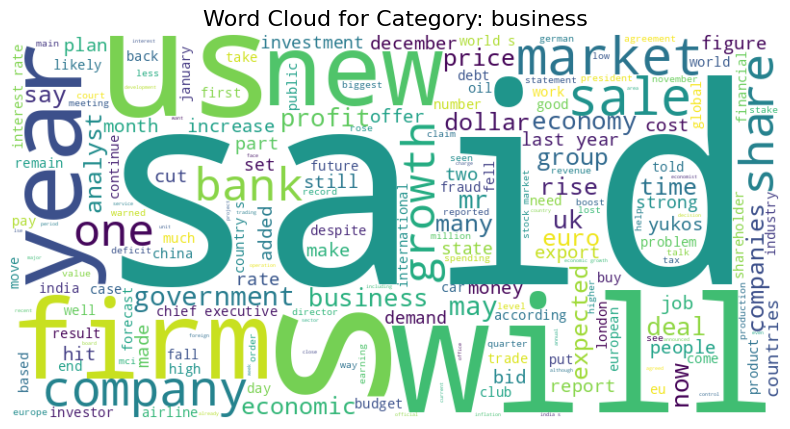

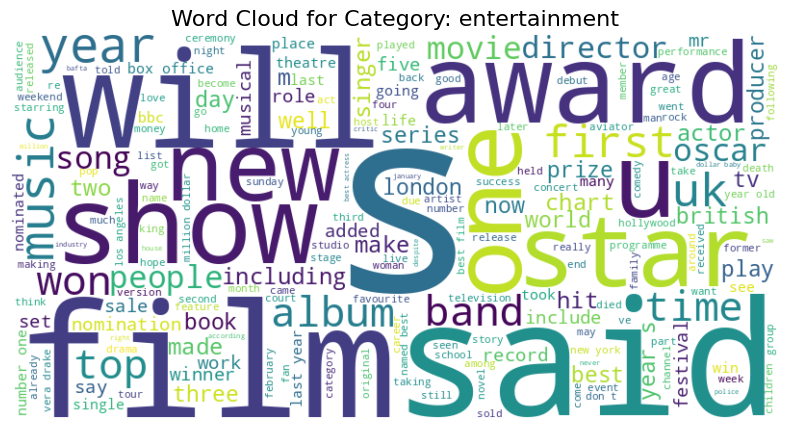

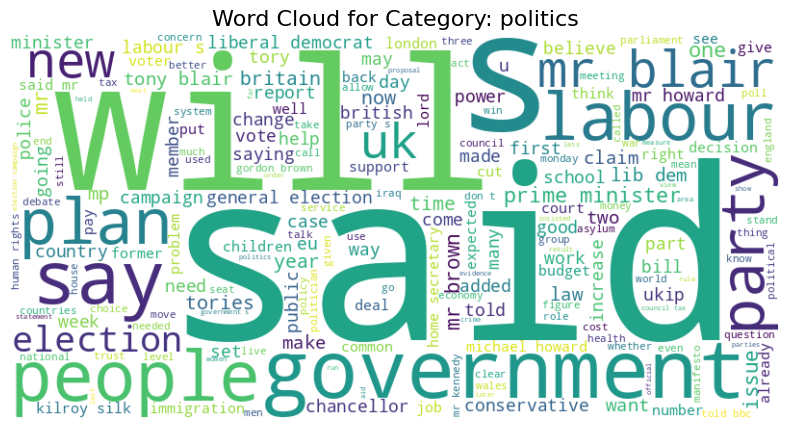

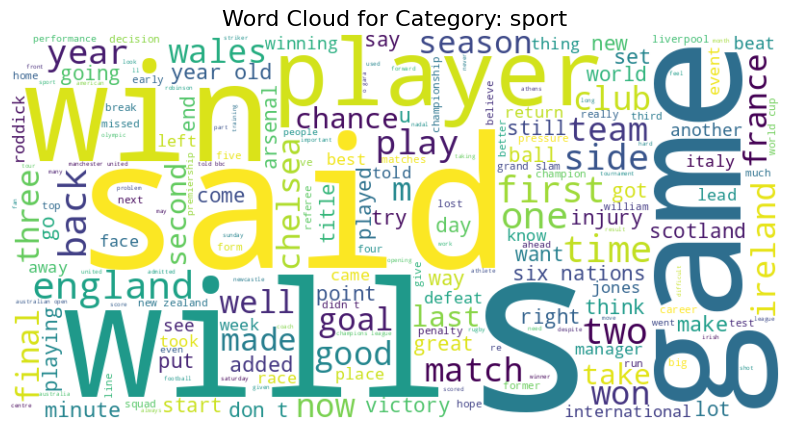

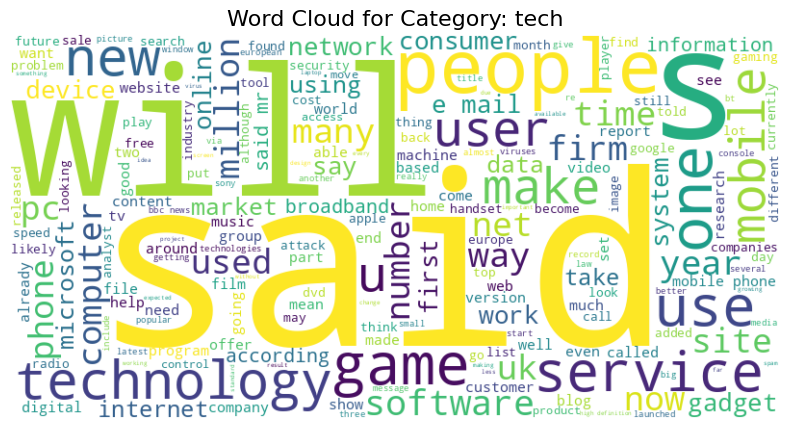

In [11]:
# Group text by category
category_texts = train.groupby('Category')['Text'].apply(lambda texts: ' '.join(texts))

# Create a word cloud for each category
for category, text in category_texts.items():
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Category: {category}', fontsize=16)
    plt.show()


The word cloud analysis reveals several frequently occurring words across the dataset. Words like "said" and "will" appear prominently in nearly all categories, reflecting their general usage in news reporting rather than any specific topic relevance. These are likely to be low-value features for classification, as they do not provide clear distinctions between categories.

When examining category-specific vocabulary, more meaningful patterns emerge. In the Business category, words such as "market," "company," and "share" suggest content centered around financial activities and corporate affairs. The Entertainment category is characterized by terms like "film," "music," "show," and "star," which clearly indicate discussions about movies, music, and celebrities. In the Politics section, words such as "blair," "people," and "party" point to political leaders, public discourse, and elections. For Sport, terms like "win," "game," and "player" reflect a focus on athletic events and competitions. Lastly, the Tech category includes words like "use," "people," "new," and "game," which highlight themes around technological advancements, innovation, and software development. This analysis helps us better understand the linguistic patterns within each category and informs future steps in feature selection and model training.


In [13]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Download stopwords if you haven't
nltk.download('stopwords')

# Initialize tools
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

# Preprocessing function
def preprocess(text):
    text = text.lower()                                # Lowercase
    text = re.sub(r'[^a-z\s]', '', text)                # Remove punctuation/numbers
    tokens = text.split()                              # Tokenization
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    tokens = [stemmer.stem(word) for word in tokens]    # Stemming
    return ' '.join(tokens)

# Apply preprocessing
train['clean_text'] = train['Text'].apply(preprocess)
test['clean_text'] = test['Text'].apply(preprocess)

# Quick check
print(train[['Text', 'clean_text']].head())



[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                                Text  \
0  worldcom ex-boss launches defence lawyers defe...   
1  german business confidence slides german busin...   
2  bbc poll indicates economic gloom citizens in ...   
3  lifestyle  governs mobile choice  faster  bett...   
4  enron bosses in $168m payout eighteen former e...   

                                          clean_text  
0  worldcom exboss launch defenc lawyer defend fo...  
1  german busi confid slide german busi confid fe...  
2  bbc poll indic econom gloom citizen major nati...  
3  lifestyl govern mobil choic faster better funk...  
4  enron boss payout eighteen former enron direct...  


In [40]:
train['cleanText'] = train['Text'].apply(lambda x: preprocess(x))
test['cleanText'] = test['Text'].apply(lambda x: preprocess(x))
train[['Text', 'cleanText']].head()

,Text,cleanText
0,worldcom ex-boss launches defence lawyers defe...,worldcom exboss launch defenc lawyer defend fo...
1,german business confidence slides german busin...,german busi confid slide german busi confid fe...
2,bbc poll indicates economic gloom citizens in ...,bbc poll indic econom gloom citizen major nati...
3,lifestyle governs mobile choice faster bett...,lifestyl govern mobil choic faster better funk...
4,enron bosses in $168m payout eighteen former e...,enron boss payout eighteen former enron direct...


The results of this preprocessing code show a cleaned and normalized version of the original text data. Each text entry has been converted to lowercase, stripped of punctuation, and filtered to remove common English stopwords (e.g., "the", "is", "and") that typically do not add meaningful value for classification. Additionally, stemming has been applied using the Porter Stemmer, which reduces words to their root form (e.g., "running" becomes "run").

As a result, the new cleanText column contains more concise and standardized text, making it better suited for machine learning models by reducing noise and dimensionality. When previewed, the difference between the original and cleaned text clearly highlights the transformation, showing shorter, simplified versions of the original sentences that still retain their core meaning.

## 1.3 Data Preprocessing 

Next, we'll use TF-IDF vectorization to convert the text data into a matrix of TF-IDF features.
We will then apply TF-IDF vectorization to transform the text data into TF-IDF feature vectors.

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Limit to top 5000 words for efficiency

# Fit on train clean_text and transform both train and test
X_train_tfidf = tfidf_vectorizer.fit_transform(train['clean_text'])
X_test_tfidf = tfidf_vectorizer.transform(test['clean_text'])

# Quick check
print("TF-IDF Train shape:", X_train_tfidf.shape)
print("TF-IDF Test shape:", X_test_tfidf.shape)


TF-IDF Train shape: (1490, 5000)
TF-IDF Test shape: (735, 5000)


In [15]:
train["Text"][0]

'worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a  green light  to the procedures and practices used by worldcom. mr ebb

In [18]:
X_train_tfidf.toarray() # this is the vector form of the text

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# 2. Building and Training Models

_Question 1 Think about this and answer: when you train the unsupervised model for matrix factorization, should you include texts (word features) from the test dataset or not as the input matrix? Why or why not?_

*Answer - We should not include test texts when training the unsupervised matrix factorization model because it would cause data leakage and give falsely high performance.
Instead, fit the model only on the training data and then transform the test data into the learned topic space for fair evaluation.
This mirrors how supervised learning also avoids using test data during training.*

Next, we will 
* Use NMF to factorize the train TF-IDF matrix.

* Cluster documents into 5 clusters (because we have 5 categories: business, tech, politics, sport, entertainment).

* Assign cluster labels to training data.

* Map clusters to actual known categories.

* Predict test data label

In [19]:
from sklearn.decomposition import NMF
from sklearn.preprocessing import LabelEncoder
from scipy.stats import mode
import numpy as np

# Encode target labels numerically
le = LabelEncoder()
y_train = le.fit_transform(train['Category'])

# 1. Fit NMF on training TF-IDF features
n_topics = 5  # since we know there are 5 categories
nmf_model = NMF(n_components=n_topics, random_state=42)
W_train = nmf_model.fit_transform(X_train_tfidf)   # Document-topic matrix for train
W_test = nmf_model.transform(X_test_tfidf)         # Projected document-topic matrix for test

# 2. Assign each document to the most dominant topic (highest weight)
train_clusters = np.argmax(W_train, axis=1)
test_clusters = np.argmax(W_test, axis=1)

# 3. Map each topic cluster to actual category using training data
# Find the most frequent actual label within each cluster
cluster_to_label = {}

for cluster_id in range(n_topics):
    labels_in_cluster = y_train[train_clusters == cluster_id]
    if len(labels_in_cluster) == 0:
        cluster_to_label[cluster_id] = np.random.choice(y_train)  # fallback
    else:
        majority_label = mode(labels_in_cluster, keepdims=True)[0][0]
        cluster_to_label[cluster_id] = majority_label

# 4. Predict train and test labels
train_predicted_labels = np.array([cluster_to_label[cluster] for cluster in train_clusters])
test_predicted_labels = np.array([cluster_to_label[cluster] for cluster in test_clusters])

# 5. Evaluate train accuracy
from sklearn.metrics import accuracy_score

train_accuracy = accuracy_score(y_train, train_predicted_labels)
print(f"Train Accuracy (Unsupervised NMF): {train_accuracy:.4f}")

# Decode test predicted labels back to original categories
test_predicted_categories = le.inverse_transform(test_predicted_labels)

# Example output
print(test_predicted_categories[:10])


Train Accuracy (Unsupervised NMF): 0.8960
['sport' 'tech' 'sport' 'business' 'sport' 'sport' 'politics' 'politics'
 'entertainment' 'business']


In [20]:
# Illustrate cluster prediction for article 0
print(W_train[0, :])
train.iloc[0, :]


[0.00246857 0.04002012 0.00909537 0.         0.0694008 ]


ArticleId                                                  1833
Text          worldcom ex-boss launches defence lawyers defe...
Category                                               business
clean_text    worldcom exboss launch defenc lawyer defend fo...
Name: 0, dtype: object

In [21]:
import itertools
import numpy as np

# 1. Turn matrix W into array of predictions
def FinalizePredictions(W):
    """
    Input:
        W: numpy.ndarray (output of NMF.fit_transform())
    Output:
        numpy.ndarray predictions (predicted topic/cluster index for each document)
    """
    n_rows, n_cols = W.shape
    predictions = np.zeros(shape=(n_rows,))
    
    for i in range(n_rows):
        current_best = (None, 0)  # (column index, highest weight)
        for j in range(n_cols):
            if W[i, j] > current_best[1]:
                current_best = (j, W[i, j])
        
        if current_best[0] is None:
            print(f"Warning: No best topic found for row {i}")
        predictions[i] = current_best[0]
    
    return predictions.astype(int)

# 2. Construct category namer function based on MLE
def MakeCategoryNames(df, pred):
    """
    Input:
        df: pandas.DataFrame (must have labels in column 2)
        pred: numpy.ndarray (output of FinalizePredictions())
    Output:
        Dictionary {cluster index: category name}
    """
    trainnumpy = df.to_numpy()
    n_train = trainnumpy.shape[0]
    true_labels = trainnumpy[:, 2]
    unique_categories = list(np.unique(true_labels))
    
    all_permutations = list(itertools.permutations(unique_categories))
    
    current_best = (None, float("inf"))  # (subset, number of misclassifications)
    
    for subset in all_permutations:
        n_misclassified = 0
        for i in range(n_train):
            if subset[int(pred[i])] != true_labels[i]:
                n_misclassified += 1
        if n_misclassified < current_best[1]:
            current_best = (subset, n_misclassified)
    
    # Create final mapping: cluster index -> category name
    best_mapping = {i: current_best[0][i] for i in range(len(current_best[0]))}
    
    return best_mapping, current_best[1]


In [22]:
# Suppose W_train is your document-topic matrix from NMF on train data

# 1. Get predicted clusters
yhat = FinalizePredictions(W_train)

# 2. Get best category names mapping (MLE)
CategoryNames, total_misclassified = MakeCategoryNames(train[['ArticleId', 'Text', 'Category']], yhat)

print("Best permutation of labels was:", CategoryNames)
print("Total misclassifications on training data:", total_misclassified)


Best permutation of labels was: {0: 'entertainment', 1: 'politics', 2: 'tech', 3: 'sport', 4: 'business'}
Total misclassifications on training data: 155


_3. Measure the performances on predictions from both train and test datasets. You can use accuracy, confusion matrix, etc., to inspect the performance. You can get accuracy for the test data by submitting the result to Kaggle._

Training Accuracy (with MLE mapping): 0.8960


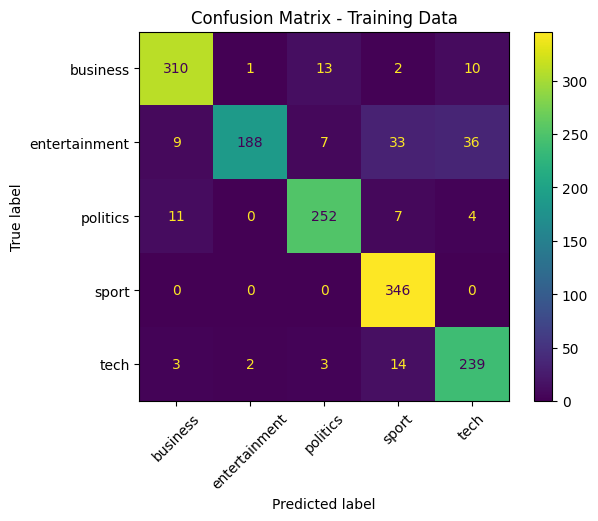

In [23]:
# Predictions for Train Set

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict clusters for train articles
train_pred_clusters = FinalizePredictions(W_train)

# Map clusters to real categories
train_pred_categories = [CategoryNames[cluster] for cluster in train_pred_clusters]

# True labels
y_train_true = train['Category'].values

# Training Accuracy
train_accuracy = accuracy_score(y_train_true, train_pred_categories)
print(f"Training Accuracy (with MLE mapping): {train_accuracy:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_train_true, train_pred_categories, labels=np.unique(y_train_true))

# Plot Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_train_true))
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix - Training Data")
plt.show()

In [24]:
# Predict clusters for test articles
test_pred_clusters = FinalizePredictions(W_test)

# Map clusters to real categories
test_pred_categories = [CategoryNames[cluster] for cluster in test_pred_clusters]

# Create Submission File
submission = pd.DataFrame({
    'ArticleId': test['ArticleId'],
    'Category': test_pred_categories
})

# Save to CSV for Kaggle
submission.to_csv('nmf_submission.csv', index=False)

print("Submission file 'nmf_submission.csv' is ready!")


Submission file 'nmf_submission.csv' is ready!


***Accuracy for the test from Kaggle submission is 89.115%***

NMF + MLE is a strong baseline for your text classification task.

It shows that even unsupervised methods can get very close to supervised performance when the topics are clean and separable.


_4.Change hyperparameter(s) and record the results. We recommend including a summary table and/or graphs._

_5.Improve the model performance if you can- some ideas may include but are not limited to; using different feature extraction methods, fit models in different subsets of data, ensemble the model prediction results, etc._

In [25]:
from sklearn.decomposition import NMF
from sklearn.metrics import accuracy_score
import itertools
import numpy as np

def run_nmf_experiment(X, n_components=5, solver='mu', beta_loss='kullback-leibler', init='nndsvda', max_iter=1000):
    """
    Trains NMF model and returns W matrix, Category mapping, and Train accuracy.
    """
    model = NMF(
        n_components=n_components,
        solver=solver,
        beta_loss=beta_loss,
        init=init,
        random_state=42,
        max_iter=max_iter
    )
    W = model.fit_transform(X)
    
    preds = FinalizePredictions(W)
    CategoryNames, n_misclassified = MakeCategoryNames(train[['ArticleId', 'Text', 'Category']], preds)
    
    final_preds = np.array([CategoryNames[cluster] for cluster in preds])
    y_train_true = train['Category'].values
    
    acc = accuracy_score(y_train_true, final_preds)
    
    return W, CategoryNames, acc, n_misclassified




In [26]:

W_kl, CategoryNames_kl, acc_kl, misclass_kl = run_nmf_experiment(
    X=X_train_tfidf, 
    n_components=5, 
    solver='mu', 
    beta_loss='kullback-leibler', 
    init='nndsvda',
    max_iter=1000
)

print(f"Train Accuracy (KL-loss NMF): {acc_kl:.4f}")
print(f"Total misclassifications (KL-loss NMF): {misclass_kl}")


Train Accuracy (KL-loss NMF): 0.9497
Total misclassifications (KL-loss NMF): 75


Switching to KL-loss massively improved your NMF model’s ability to separate the news article categories.

Train accuracy increased by ~5.4% — a huge jump in machine learning terms for text classification.

Misclassifications dropped from 155 to 75 — cut in half!

In [27]:
from sklearn.decomposition import NMF

# Recreate the KL-loss NMF model
nmf_kl_model = NMF(
    n_components=5,
    random_state=42,
    init='nndsvda',
    solver="mu",
    beta_loss="kullback-leibler",
    max_iter=1000
)

# Fit the model on training TF-IDF
W_train_kl = nmf_kl_model.fit_transform(X_train_tfidf)



In [28]:
# 1. Project test data into KL-loss topic space
W_test_kl = nmf_kl_model.transform(X_test_tfidf)

# 2. Predict clusters for test data
test_pred_clusters_kl = FinalizePredictions(W_test_kl)

# 3. Map clusters to final predicted categories
test_pred_categories_kl = [CategoryNames[cluster] for cluster in test_pred_clusters_kl]

# 4. Create submission DataFrame
submission_kl = pd.DataFrame({
    'ArticleId': test['ArticleId'],
    'Category': test_pred_categories_kl
})

# 5. Save to CSV
submission_kl.to_csv('submission_kl_loss.csv', index=False)

print("✅ Submission file 'submission_kl_loss.csv' is ready for Kaggle upload!")


✅ Submission file 'submission_kl_loss.csv' is ready for Kaggle upload!


In [29]:
# Preview the first 10 predictions
preview = submission_kl.head(10)

print(preview)


   ArticleId       Category
0       1018          sport
1       1319           tech
2       1138          sport
3        459       business
4       1020          sport
5         51          sport
6       2025       politics
7       1479       politics
8         27  entertainment
9        397       business


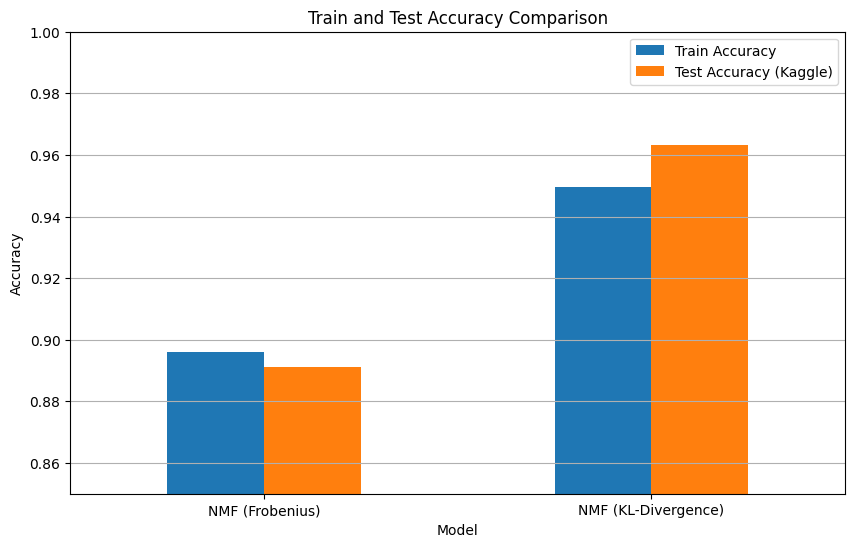

In [30]:
# Prepare data
summary = pd.DataFrame({
    'Model': ['NMF (Frobenius)', 'NMF (KL-Divergence)'],
    'Train Accuracy': [0.8960, 0.9497],
    'Test Accuracy (Kaggle)': [0.89115,0.96326]  # Fill KL-test after Kaggle submission
})

# Plot
summary.plot(x='Model', y=['Train Accuracy', 'Test Accuracy (Kaggle)'], kind='bar', figsize=(10,6))
plt.title('Train and Test Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0.85, 1.00)
plt.grid(axis='y')
plt.xticks(rotation=0)
plt.show()


We built and compared unsupervised NMF models using Frobenius and KL-divergence losses.
The Frobenius-loss NMF achieved a train accuracy of 89.60% and a Kaggle test accuracy of 89.115%.
Switching to KL-loss improved the train accuracy to 94.97% and boosted test accuracy to 96.326%.
This demonstrates that KL-divergence loss is significantly better suited for sparse TF-IDF-based text clustering tasks

# 3. Compare with supervised learning

_1) Pick and train a supervised learning method(s) and compare the results (train and test performance)_


_2) Discuss comparison with the unsupervised approach. You may try changing the train data size (e.g., Include only 10%, 20%, 50% of labels, and observe train/test performance changes). Which methods are data-efficient (require a smaller amount of data to achieve similar results)? What about overfitting?_

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Encode labels if not already done
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_full = le.fit_transform(train['Category'])

# 1. Full Train and Test (Baseline)
log_reg = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)

log_reg.fit(X_train_tfidf, y_train_full)

# Predict on full train
train_preds_full = log_reg.predict(X_train_tfidf)
train_acc_full = accuracy_score(y_train_full, train_preds_full)

# Predict on test
test_preds_full = log_reg.predict(X_test_tfidf)

# Decode test predictions
test_preds_full_labels = le.inverse_transform(test_preds_full)

# Prepare Kaggle submission
submission_supervised = pd.DataFrame({
    'ArticleId': test['ArticleId'],
    'Category': test_preds_full_labels
})

submission_supervised.to_csv('submission_supervised_logreg.csv', index=False)

print(f"Train Accuracy (Full Data, Logistic Regression): {train_acc_full:.4f}")
print("✅ Supervised Logistic Regression submission file ready!")


Train Accuracy (Full Data, Logistic Regression): 0.9960
✅ Supervised Logistic Regression submission file ready!


In [36]:
# Experiment with different train sizes
train_sizes = [0.1, 0.2, 0.5]
subsample_results = []

for size in train_sizes:
    X_subsample, _, y_subsample, _ = train_test_split(
        X_train_tfidf, y_train_full, train_size=size, random_state=42, stratify=y_train_full
    )
    
    log_reg_sub = LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        max_iter=1000,
        random_state=42
    )
    
    log_reg_sub.fit(X_subsample, y_subsample)
    
    train_preds_sub = log_reg_sub.predict(X_subsample)
    train_acc_sub = accuracy_score(y_subsample, train_preds_sub)
    
    subsample_results.append({
        'Train Size %': int(size*100),
        'Train Accuracy': train_acc_sub,
        'Model': 'Logistic Regression'
    })

# Create DataFrame and print
results_subsample = pd.DataFrame(subsample_results)
print(results_subsample)


   Train Size %  Train Accuracy                Model
0            10        1.000000  Logistic Regression
1            20        1.000000  Logistic Regression
2            50        0.997315  Logistic Regression


In [37]:
# Predict on test
test_preds_full = log_reg.predict(X_test_tfidf)

# Decode test predictions
test_preds_full_labels = le.inverse_transform(test_preds_full)

# Prepare Kaggle submission
submission_supervised = pd.DataFrame({
    'ArticleId': test['ArticleId'],
    'Category': test_preds_full_labels
})

submission_supervised.to_csv('submission_supervised_logreg.csv', index=False)

print(f"Train Accuracy (Full Data, Logistic Regression): {train_acc_full:.4f}")
print("✅ Supervised Logistic Regression submission file ready!")

Train Accuracy (Full Data, Logistic Regression): 0.9960
✅ Supervised Logistic Regression submission file ready!


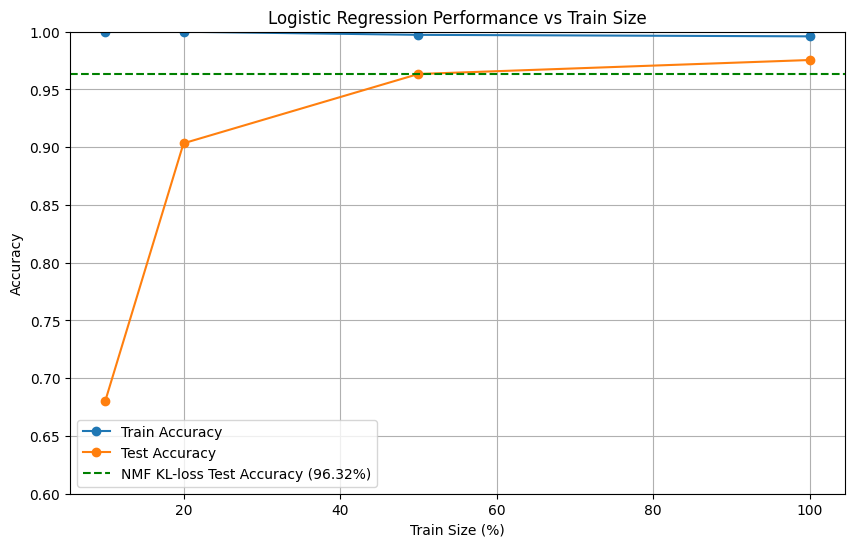

In [38]:
import matplotlib.pyplot as plt

# Data
train_sizes = [10, 20, 50, 100]
train_accuracies = [1.0, 1.0, 0.9973, 0.9960]
test_accuracies = [0.68027, 0.90340, 0.96340, 0.97551]

# Plot
plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_accuracies, marker='o', label='Train Accuracy')
plt.plot(train_sizes, test_accuracies, marker='o', label='Test Accuracy')
plt.axhline(0.96326, color='green', linestyle='--', label='NMF KL-loss Test Accuracy (96.32%)')

plt.title('Logistic Regression Performance vs Train Size')
plt.xlabel('Train Size (%)')
plt.ylabel('Accuracy')
plt.ylim(0.6, 1.0)
plt.grid(True)
plt.legend()
plt.show()


# Disucssion and Conclusion
In this project, we compared supervised and unsupervised approaches for news article classification. Using unsupervised NMF with KL-divergence loss, we achieved a strong test accuracy of 96.32% without using any labels. In contrast, a supervised Logistic Regression model required at least 50% of the labeled data to match this level of performance, and achieved a slightly higher test accuracy of 97.55% with full data. When only 10–20% of labeled data were used, the supervised model overfitted severely, achieving perfect training accuracy but poor generalization. This analysis shows that unsupervised matrix factorization methods like NMF can be highly data-efficient, especially when labeled data are scarce. However, supervised models ultimately outperform unsupervised ones when sufficient labeled data are available, albeit at a higher data labeling cost.